In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, default_data_collator, \
    DataCollatorForLanguageModeling
from datasets import load_dataset
from arguments import DataTrainingArguments, ModelArguments, TrainingArguments
from collections import defaultdict
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import color_idx, room_idx

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base', legacy=True)

# Initialize the data arguments
data_args = DataTrainingArguments(
    datasets='floorplan',
    data_dir=None,
    train_split='train',
    max_seq_length=512,
    max_output_seq_length=512,
    max_seq_length_eval=512,
    max_output_seq_length_eval=512,
    exp='full',
    boundary_in_where='Encoder'
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
model = T5ForConditionalGeneration.from_pretrained(
    'experiments/floorplan-t5-base-full-ep50-len512-lr1e-07-b4-train-original-baseline/episode0')

In [3]:
# Example usage
input_sentence = "Balcony 1 is about 8 foot X 2 foot.  This is located right off of the kitchen. Balcony 2 is about 10 foot X 3 foot.  This is facing north of the house. The bathroom is about 8 foot X 6 foot.  It is located between the living room and the kitchen. Common room 1 is about 10 foot X 12 foot.  The common rooms are located diagonal from each other. Common room 2 is about 10 foot X 10 foot.  The common rooms are located diagonal from each other. The kitchen is a 10 foot X 10 foot room.  It looks like it is opened up to the living room. The living room is located on the east side of the house.  It is shaped like a \"T\" and it's the biggest room.  It is approximately 14 feet X 32 feet.  Each room that you come out of you will enter the living room. The master is about 10 feet X 15 feet.  It is located far west of the house.It is a rectangle shape."
input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids

# Generate output
output_ids = model.generate(input_ids, max_new_tokens=512)
output_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Output sentence:", output_sentence)

Output sentence: [ master room | x coordinate = 178 | y coordinate = 178 | height = 63 | width = 47 ] [ bathroom 2 | x coordinate = 100 | y coordinate = 143 | height = 45 | width = 18 ] [ common room 1 | x coordinate = 163 | y coordinate = 76 | height = 62 | width = 42 ] [ common room 2 | x coordinate = 100 | y coordinate = 173 | height = 45 | width = 37 ] [ living room | x coordinate = 136 | y coordinate = 120 | height = 116 | width = 97 ] [ bathroom 1 | x coordinate = 142 | y coordinate = 187 | height = 32 | width = 30 ] [ balcony | x coordinate = 204 | y coordinate = 122 | height = 11 | width = 57 ] [ kitchen | x coordinate = 74 | y coordinate = 83 | height = 54 | width = 23 ]


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [5]:
from datasets import load_dataset

test_dataset = load_dataset('floorplan', data_args, split='finetune',
                            max_input_length=data_args.max_seq_length,
                            max_output_length=data_args.max_output_seq_length,
                            tokenizer=tokenizer, seed=1)

In [6]:
test_dataset.get_example(0)

InputExample(id='finetune-512', tokens=['Directly', 'behind', 'the', 'kitchen', ';', 'on', 'the', 'north', 'end', 'of', 'the', 'floor', 'plan', '.', 'Directly', 'south', 'in', 'the', 'floor', 'plan', '.', 'Borders', 'the', 'living', 'room', 'to', 'the', 'south', '.', 'Next', 'to', 'common', 'room', ',', 'parallel', 'to', 'the', 'entrance', '.', '3', 'rd', 'biggest', 'room', 'in', 'house', ',', 'wedged', 'in', 'between', 'bathroom', 'and', 'kitchen', '.', 'Directly', 'north', 'of', 'living', 'room', '.', 'Borders', 'common', 'room', 'on', 'the', 'west', '.', 'Balcony', 'directly', 'behind', 'kitchen', '.', 'Living', 'room', 'borders', 'balcony', 'at', 'south', ',', 'touches', 'kitchen', 'at', 'north', '.', 'Touches', 'bathroom', 'directly', 'northwest', 'and', 'the', 'master', 'bedroom', 'south', 'west', '.', 'Biggest', 'room', 'in', 'house', '.', '2nd', 'biggest', 'room', 'in', 'house', '.', 'South', 'West', 'on', 'the', 'floor', 'plan', '.'], dataset=Dataset floorplan, rooms=[Room(typ

In [7]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=default_data_collator)


def generate_output_sentences():
    for i, inputs in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
        predictions = model.generate(
            inputs['input_ids'].to(device),
            max_length=data_args.max_output_seq_length_eval,
            num_beams=5,
            decoder_input_ids=inputs['decoder_boundary_ids']
        )
        for j, (input_ids, label_ids, prediction) in enumerate(
                zip(inputs['input_ids'], inputs['labels'], predictions)):
            current_id = i * batch_size + j
            example = test_dataset.get_example(current_id)
            output_sentence = tokenizer.decode(prediction, skip_special_tokens=True, clean_up_tokenization_spaces=False)
            yield example, output_sentence, None

In [26]:
def generate_one_output_sentence():
    # Get the first batch from the test_data_loader
    inputs = next(iter(test_data_loader))

    # Generate prediction
    predictions = model.generate(
        inputs['input_ids'].to(device),
        max_length=data_args.max_output_seq_length_eval,
        num_beams=5,
        decoder_input_ids=inputs['decoder_boundary_ids']
    )

    # Get the first prediction
    prediction = predictions[0]

    # Get the first example
    example = test_dataset.get_example(0)

    # Decode the prediction to get the output sentence
    output_sentence = tokenizer.decode(prediction, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return example, output_sentence, None

In [27]:
example, output_sentence, predicted_index = generate_one_output_sentence()
print(test_dataset.input_format.format_input(example, multitask=False))
print("Output sentence:", output_sentence[51:])

Directly behind the kitchen ; on the north end of the floor plan . Directly south in the floor plan . Borders the living room to the south . Next to common room , parallel to the entrance . 3 rd biggest room in house , wedged in between bathroom and kitchen . Directly north of living room . Borders common room on the west . Balcony directly behind kitchen . Living room borders balcony at south , touches kitchen at north . Touches bathroom directly northwest and the master bedroom south west . Biggest room in house . 2nd biggest room in house . South West on the floor plan .
Output sentence: [ master room | x coordinate = 178 | y coordinate = 178 | height = 63 | width = 42 ] [ bathroom 2 | x coordinate = 143 | height = 45 | width = 42 ] [ common room 2 | x coordinate = 100 | y coordinate = 173 | height = 32 | width = 30 ] [ living room | x coordinate = 142 | y coordinate = 143 | height = 45 | width = 37 ] [ bathroom 1 | x coordinate = 136 | y coordinate = 120 | height = 11 | width = 97 

In [10]:
output_sentence[51:]

'[ master room | x coordinate = 178 | y coordinate = 178 | height = 63 | width = 42 ] [ bathroom 2 | x coordinate = 143 | height = 45 | width = 42 ] [ common room 2 | x coordinate = 100 | y coordinate = 173 | height = 32 | width = 30 ] [ living room | x coordinate = 142 | y coordinate = 143 | height = 45 | width = 37 ] [ bathroom 1 | x coordinate = 136 | y coordinate = 120 | height = 11 | width = 97 ] [ bathroom 1 | x coordinate = 142 | y coordinate = 187 | height = 32 | width = 30 ] [ kitchen | x coordinate = 74 | y coordinate = 83 | height = 54 | width = 23 ]'

In [11]:
gt_boxes = defaultdict(list)
for room in example.rooms:
    gt_x, gt_y, gt_h, gt_w = room.x, room.y, room.h, room.w
    gt_box = [
        [int(gt_x - gt_h / 2), int(gt_y - gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y - gt_w / 2)],
        [int(gt_x - gt_h / 2), int(gt_y + gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y + gt_w / 2)]
    ]
    gt_boxes[room.type] = gt_box

In [12]:
res = test_dataset.output_format.run_inference(example, output_sentence[51:], predicted_index)
predicted_rooms_by_name, predicted_rooms, raw_predicted_relations, wrong_reconstruction, format_error, label_error = res

In [13]:
predicted_attribute = defaultdict()
for attribute_tuple in raw_predicted_relations:
    attribute_type,value, room_tuple, room_type = attribute_tuple
    if room_type not in predicted_attribute:
        predicted_attribute[room_type] = defaultdict()
    try:
        value = int(value)
    except:
        value = 128
    predicted_attribute[room_type][attribute_type] = value

In [14]:
# TODO: examine the predicted_attribute patterns
correct_attributes = ['x coordinate', 'y coordinate', 'height', 'width']
wrong_room = []
for room_type in predicted_attribute:
    if set(list(predicted_attribute[room_type].keys())) != set(correct_attributes):
        print('wrong output format:')
        print(predicted_attribute[room_type])
        wrong_room.append(room_type)
for wrong_r in wrong_room:
    predicted_attribute.pop(wrong_r)

wrong output format:
defaultdict(None, {'x coordinate': 143, 'height': 45, 'width': 42})


In [15]:
all_gt_rooms = [room.type for room in example.rooms]
predicted_boxes = defaultdict()
for room in predicted_attribute:
    predicted_boxes[room] = [
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)]
    ]


In [16]:
for room in gt_boxes:
    y_min = gt_boxes[room][0][1]
    x_min = gt_boxes[room][0][0]
    y_max = gt_boxes[room][3][1]
    x_max = gt_boxes[room][3][0]
    gt_boxes[room] = (y_min, x_min, y_max, x_max)

In [17]:
for room in predicted_boxes:
    y_min = predicted_boxes[room][0][1]
    x_min = predicted_boxes[room][0][0]
    y_max = predicted_boxes[room][3][1]
    x_max = predicted_boxes[room][3][0]
    predicted_boxes[room] = (y_min, x_min, y_max, x_max)

In [18]:
# render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes, output_dir)

In [19]:
def render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes):
    image_height = 256
    image_width = 256
    number_of_color_channels = 3
    background_color = (255, 255, 255)
    gt_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    predicted_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    boundary_color = [0, 0, 0]

    left_boundary = int(example.boundary_tokens[1])

    living = defaultdict()
    common = defaultdict()
    master = defaultdict()
    balcony = defaultdict()
    bathroom = defaultdict()
    kitchen = defaultdict()
    storage = defaultdict()
    dining = defaultdict()
    for room in predicted_boxes:
        if room.startswith('living'):
            living[room] = predicted_boxes[room]
        elif room.startswith('common'):
            common[room] = predicted_boxes[room]
        elif room.startswith('master'):
            master[room] = predicted_boxes[room]
        elif room.startswith('balcony'):
            balcony[room] = predicted_boxes[room]
        elif room.startswith('bathroom'):
            bathroom[room] = predicted_boxes[room]
        elif room.startswith('kitchen'):
            kitchen[room] = predicted_boxes[room]
        elif room.startswith('storage'):
            storage[room] = predicted_boxes[room]
        elif room.startswith('dining'):
            dining[room] = predicted_boxes[room]
    room_type_list = [living, common, master, balcony, bathroom, kitchen, storage, dining]
    for room_type in room_type_list:
        for room in room_type:
            left_top_pr = (room_type[room][0], room_type[room][1])
            right_bt_pr = (room_type[room][2], room_type[room][3])

            color = color_idx[room_idx[room]]
            # draw room on predicted image
            cv2.rectangle(predicted_image, left_top_pr, right_bt_pr, color, -1)

    for boundary_pixel in example.boundary:
        predicted_image[boundary_pixel[0], boundary_pixel[1]] = boundary_color

    return predicted_image

In [20]:
pre_image = render_image_(example, gt_boxes, all_gt_rooms, gt_boxes)

In [21]:
import matplotlib.patches as mpatches

def render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes):
    # Render the image as before
    image = render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Create a legend
    patches = [mpatches.Patch(color=np.array(color_idx[room_idx[room]])/255., label=room) for room in all_gt_rooms]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()

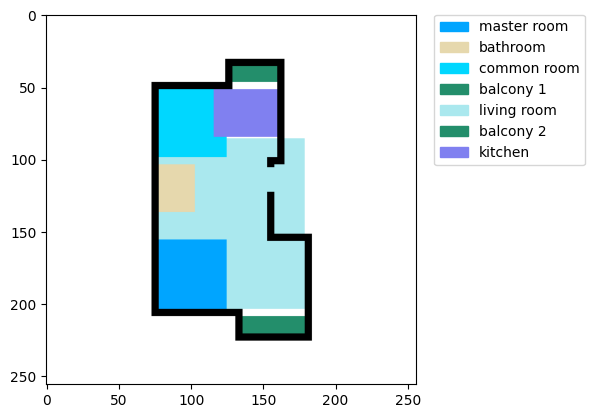

In [22]:
render_image_with_legend(example, gt_boxes, all_gt_rooms, gt_boxes)

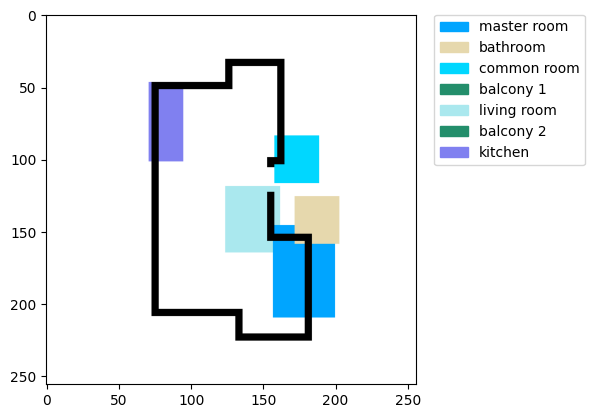

In [23]:
render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes)